In [1]:
import os
import re
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
# from keras.layers import Embedding
from  keras . utils  import  to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Permute
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
df_train=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_train.csv')
df_test=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_test.csv')
total_data = pd.concat([df_train,df_test])
# we have to works with word level,if we works with charchter level then it exits the RAM limit
# here remove 'politics','education','sports' labels of text which is frequently occur in dataset and set it to news_3less.csv file
total_data = total_data[total_data['label']!='politics'] # remove the label which is 'politics'
total_data = total_data[total_data['label']!='education'] # remove the label which is 'education'
total_data = total_data[total_data['label']!='sports'] # remove the label which is 'sports'
print(len(total_data))
# df.to_csv(news/'news_3less.csv',index=False) # convert the data to csv format

51690


In [4]:
set(total_data.label)

{'accident',
 'art',
 'crime',
 'economics',
 'entertainment',
 'environment',
 'international',
 'opinion',
 'science_tech'}

In [5]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [6]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-58x1egn9
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-58x1egn9
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=1df2ba1650a4d21b2f623797945a8b119bdea50fb6ceb92633b2bee8e890519e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mmuggtuz/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [7]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-ybge_8p0
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-ybge_8p0
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=f073b4ecac402e7eef9a875f67648ac8412e462284ea1b37ccde3bbb26184490
  Stored in directory: /tmp/pip-ephem-wheel-cache-ow71f7ah/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [8]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [9]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [10]:
texts = list(total_data['text'])
labels = list(total_data['label'])


In [11]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [12]:
stopwords = pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')

In [13]:
set_stop = set(stopwords['words'])

In [14]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [15]:
texts = pre_process(texts)

In [16]:
texts[0]

'উচ্চ মাধ্যমিক পরীক্ষ মঙ্গলব বিবৃতি মন্ত্রী “আমি হরতাল অবরোধ সন্ত্রাসী কার্যক্রম পরিচালনাকারী জোট আহ্বান জানা পরীক্ষার্থী শান্তিপূর্ণভাব পরীক্ষা দয়া হটকারী ঘটনা ঘটাব “আমি ভাষা দেশ স্থান একজন পরীক্ষার্থীর ক্ষতি দায়দায়িত্ব আপনা বহন মানুষ আপনা ক্ষমা না” জানুয়ারি দেশ টানা অবরোধ চালি আসা বিএনপি জোট ফেব্রুয়ারি মার্চ বেশিরভাগ প্রতিদিন হরতাল বিএনপি জোট অবরোধ হরতাল চলতি এসএসসি সমমান অর্থাৎ দিন পরীক্ষা পেছা বাধ্য শিক্ষা মন্ত্রণাল পরীক্ষা দিন শুক্র শনিব ধরন রাজনৈতিক কর্মসূচির কারণ এইচএসসি পরীক্ষা পেছানো রেখ শিক্ষামন্ত্রী ফাইল বিবৃতি নাহিদ “সংকট এসএসসি পরীক্ষা শেষ এইচএসসি পরীক্ষা জাতির দুর্ভাগ্য রাজনৈতিক জোট বিবেকবর্জিত অব্যাহত হরতাল অবরোধ কারণ এসএসসির রুটিন পরীক্ষা সম্ভব “পরীক্ষার্থী অভিভাবক শিক্ষকসহ শ্রেণি পেশ মানুষ মতামত পরামর্শ সম্মান দেখি পরিস্থিতি রুটিনমাফিক পরীক্ষা সিদ্ধান্ত গ্রহণ করে ব্যত্য না” পরীক্ষার্থী যাতায়াত নির্বিঘ্ন আইনশৃঙ্খলা রক্ষাবাহিনীর সর্বাত্মক নজরদারি আশ্বস্ত শিক্ষামন্ত্রী “ইতিবাচক দৃষ্টিভঙ্গিসম্পন্ন রাজনৈতিক নেতা কর্মী সামাজিক সাংস্কৃতিক সংগঠন সদস্য জনগণ তোমা পাশ তোম নিশ্চিন

In [17]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes = 9 
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [18]:
d = set()
for s in texts:
    for ss in list(s.split()):
        d.add(ss)

In [19]:
len(d) # here is the total number of words in corpus, but the number of tokenizer is small then that(ther are some stopwords which is removed)

278693

In [20]:
max([len(s.split()) for s in texts]) # find the max length

7779

In [21]:
MAX_SEQUENCE_LENGTH = 7779    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 272611 + 1 # you have to use word same as tokenizer length, and add extra 1(for 0th index case)
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [22]:
len(data['tokenizer'].word_index) # after running previous cell of code we run this cell,we call the 'load_data' function before we see the len of data['tokenizer']

272611

In [23]:
max_words = 272611 + 1
max_len = 7779 
# tok = Tokenizer(num_words=max_words)
# tok.fit_on_texts(X_train)
# sequences = tok.texts_to_sequences(X_train)
# sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

LSTM only

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,300,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(9,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

    

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 7779)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 7779, 300)         81783600  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 9)                

In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), batch_size=128, epochs=10, verbose=2)
# history = m.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), batch_size=128, epochs=10, verbose=2)

Epoch 1/10
324/324 - 382s - loss: 0.1800 - accuracy: 0.6574 - val_loss: 0.1211 - val_accuracy: 0.7951
Epoch 2/10
324/324 - 384s - loss: 0.0926 - accuracy: 0.8563 - val_loss: 0.1080 - val_accuracy: 0.8266
Epoch 3/10
324/324 - 385s - loss: 0.0662 - accuracy: 0.9051 - val_loss: 0.1078 - val_accuracy: 0.8367
Epoch 4/10
324/324 - 385s - loss: 0.0509 - accuracy: 0.9271 - val_loss: 0.1087 - val_accuracy: 0.8482
Epoch 5/10
324/324 - 387s - loss: 0.0422 - accuracy: 0.9386 - val_loss: 0.1275 - val_accuracy: 0.8212
Epoch 6/10
324/324 - 384s - loss: 0.0355 - accuracy: 0.9462 - val_loss: 0.1333 - val_accuracy: 0.8005
Epoch 7/10
324/324 - 385s - loss: 0.0299 - accuracy: 0.9521 - val_loss: 0.1409 - val_accuracy: 0.8211
Epoch 8/10
324/324 - 389s - loss: 0.0251 - accuracy: 0.9586 - val_loss: 0.1266 - val_accuracy: 0.8336
Epoch 9/10
324/324 - 385s - loss: 0.0222 - accuracy: 0.9614 - val_loss: 0.1569 - val_accuracy: 0.8211
Epoch 10/10
324/324 - 382s - loss: 0.0198 - accuracy: 0.9650 - val_loss: 0.1513 - 

LSTM with ATTENTION

In [24]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,300,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(9,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [25]:
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [27]:
def model_attention_applied_after_lstm():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,300,input_length=max_len)(inputs)
    
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(9, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [28]:
from keras.layers import merge
from keras.layers import multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from keras.utils.vis_utils import plot_model

In [29]:
INPUT_DIM = 300
TIME_STEPS = max_len

In [30]:
m = model_attention_applied_after_lstm()


In [31]:
m.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 7779)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 7779, 300)    81783600    inputs[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 7779, 64)     93440       embedding[0][0]                  
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 7779)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [32]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = m.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), batch_size=128, epochs=10, verbose=2)


Epoch 1/10
324/324 - 911s - loss: 0.3380 - accuracy: 0.1937 - val_loss: 0.3370 - val_accuracy: 0.1944
Epoch 2/10
324/324 - 913s - loss: 0.3324 - accuracy: 0.2156 - val_loss: 0.3167 - val_accuracy: 0.2849
Epoch 3/10
324/324 - 905s - loss: 0.2450 - accuracy: 0.4687 - val_loss: 0.1807 - val_accuracy: 0.6389
Epoch 4/10
324/324 - 886s - loss: 0.1276 - accuracy: 0.7831 - val_loss: 0.1154 - val_accuracy: 0.8027
Epoch 5/10
324/324 - 889s - loss: 0.0746 - accuracy: 0.8838 - val_loss: 0.1072 - val_accuracy: 0.8269
Epoch 6/10
324/324 - 893s - loss: 0.0513 - accuracy: 0.9210 - val_loss: 0.0957 - val_accuracy: 0.8482
Epoch 7/10
324/324 - 889s - loss: 0.0362 - accuracy: 0.9429 - val_loss: 0.0953 - val_accuracy: 0.8485
Epoch 8/10
324/324 - 885s - loss: 0.0285 - accuracy: 0.9534 - val_loss: 0.1078 - val_accuracy: 0.8362
Epoch 9/10
324/324 - 879s - loss: 0.0245 - accuracy: 0.9587 - val_loss: 0.0983 - val_accuracy: 0.8544
Epoch 10/10
324/324 - 887s - loss: 0.0214 - accuracy: 0.9624 - val_loss: 0.1009 - 

In [35]:
accr = m.evaluate(data["X_test"],data["y_test"])
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

324/324 [==============================] - 72s 221ms/step - loss: 0.1009 - accuracy: 0.8543
Test set
  Loss: 0.101
  Accuracy: 0.854


In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [38]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


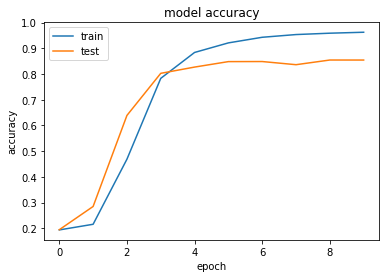

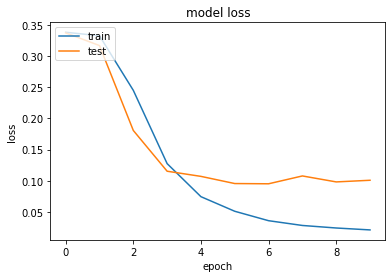

In [39]:
history2(history)

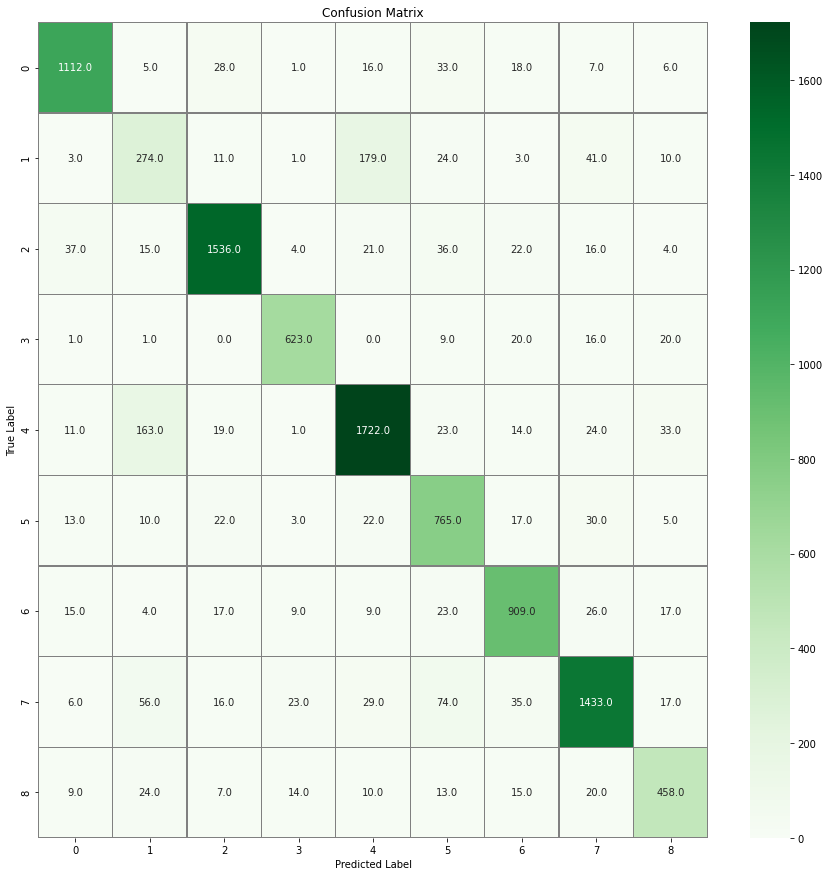

In [40]:
confussion_mat(m)

In [2]:
import keras
keras.__version__

'2.4.3'